In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.models import Sequential 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers import Lambda, Conv2D, Dropout, Dense, Flatten
from keras.regularizers import l2

from utils import INPUT_SHAPE, batch_generator

In [2]:
# thư mục lưu data
data_dir = 'E:/train/'
# đọc file driving_log.csv với cột tương ứng
data_df = pd.read_csv(os.path.join(os.getcwd(), data_dir, 'driving_log.csv'), names=[
                      'center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'])

# lấy path đến camera giữa, trái , phái
X = data_df[['center', 'left', 'right']].values
#  lấy góc lái của ô tô
y = data_df['steering'].values


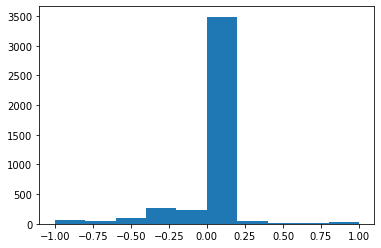

In [3]:
# draw histogram
plt.hist(y)
plt.show()

Do quá nhiều dữ liệu ở góc lái 0 tức là oto đi thẳng, nên ta sẽ loại bỏ bớt để model bớt dự đoán góc lái nghiêng về 0

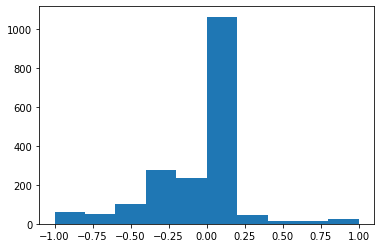

In [4]:
# loại bỏ và chỉ lấy 1000 dl có góc lái 0
pos_zero = np.array(np.where(y==0)).reshape(-1, 1)
pos_none_zero = np.array(np.where(y!=0)).reshape(-1, 1)
np.random.shuffle(pos_zero)
pos_zero = pos_zero[:1000]

pos_combined = np.vstack((pos_zero, pos_none_zero))
pos_combined = list(pos_combined)

y = y[pos_combined].reshape(len(pos_combined))
X = X[pos_combined, :].reshape(len(pos_combined), 3)

# after process
plt.hist(y)
plt.show()

Góc lái ở 0 nhiều nhất vì phần lớn oto đi thẳng. Histogram lệch bên trái ko quá quan trọng vì ta sẽ flip ảnh

In [5]:
# split train, valid set
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=0)


In [6]:
# build model
model = Sequential()
model.add(Lambda(lambda x: x/127.5 - 1.0, input_shape=INPUT_SHAPE))
model.add(Conv2D(24, (5, 5), activation='elu', strides=(2, 2)))
model.add(Conv2D(36, (5, 5), activation='elu', strides=(2, 2)))
model.add(Conv2D(48, (5, 5), activation='elu', strides=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='elu'))
model.add(Conv2D(64, (3, 3), activation='elu'))

model.add(Dropout(0.5))
model.add(Flatten())

model.add(Dense(100, activation='elu'))
model.add(Dropout(0.5))

model.add(Dense(50, activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 66, 200, 3)        0         
                                                                 
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 dropout (Dropout)           (None, 1, 18, 64)         0

In [7]:
nb_epoch = 10
samples_per_epoch = 1000
batch_size = 32
lr = 1e-4

# checkpoint lưu model nếu val loss min
checkpoint = ModelCheckpoint('models/model-{epoch:03d}.h5',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='auto')

# use mse for loss func
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=lr))

In [8]:
from utils import INPUT_SHAPE, batch_generator
# train model
H = model.fit(batch_generator(data_dir, X_train, y_train, batch_size, True),
              steps_per_epoch=samples_per_epoch,
              epochs=nb_epoch,
              max_queue_size=1,
              validation_data=batch_generator(
                  data_dir, X_val, y_val, batch_size, False),
              validation_steps=len(X_val),
              callbacks=[checkpoint],
              verbose=1)


Epoch 1/10


ValueError: in user code:

    File "c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "sequential" expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(1, 66, 200, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(1,) dtype=float32>]


In [ ]:
def nextSquare():
    i = 1
    while True:
        yield i*i, i
        i += 1

k=0
for num in nextSquare():
    k += 1
    if k > 3:
        break
    print(type(num))


<class 'tuple'>
<class 'tuple'>
<class 'tuple'>


In [9]:
from utils import INPUT_SHAPE, batch_generator, myfunc
type(batch_generator(data_dir, X_train, y_train, batch_size, True))

tuple

In [10]:
type(myfunc(1))

int